# Crypto Risk Metric
> Using machine learning to develop a risk metric

- toc: false
- badges: false
- comments: true
- categories: [Blockchain]
- image: images/chart-preview.png

In [1]:
#hide
#@title IMPORTS
# IMPORTS
import pandas as pd
import math
import os.path
import time
!pip install python-binance
# import binance
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

import numpy as np
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()
!pip install mplfinance
# More Plotting libaries 
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from dateutil.relativedelta import relativedelta

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib


# libraries for Data Download
!pip install yfinance
import datetime
from pandas_datareader import data as pdr
import yfinance as yf

### API

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440, '1w':10080}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 112kB 14.9MB/s 
     |████████████████████████████████| 1.3MB 15.7MB/s 
     |████████████████████████████████| 286kB 40.6MB/s 
     |████████████████████████████████| 184kB 33.9MB/s 
     |████████████████████████████████| 296kB 39.2MB/s 
     |████████████████████████████████| 143kB 45.9MB/s 
     |████████████████████████████████| 71kB 5.5MB/s 
--2021-07-07 10:24:25--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-07-07 10:24:26--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.ta

In [2]:
#hide
#@title binance functions

### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    #change this to 2017
    elif source == "binance": old = datetime.strptime('1 Mar 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    # change this to 2017
    if oldest_point == datetime.strptime('1 Mar 2017', '%d %b %Y'): None#  print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
     # print('All caught up..!')
    return data_df


def StochRSI(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.rolling(smoothK).mean()
    stochrsi_D = stochrsi_K.rolling(smoothD).mean()

    return stochrsi_K, stochrsi_D

def StochRSI_EMA(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.ewm(span=smoothK).mean()
    stochrsi_D = stochrsi_K.ewm(span=smoothD).mean()

    return stochrsi_K, stochrsi_D

In [3]:
#hide
#@title Plot Function

def plot(data,n_days,tickax):
  data = data.tail(n_days)

  sns.set_style("whitegrid")

  fig = plt.figure()
  fig.set_size_inches((30, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))

  ohlc = []
  for date, row in data.iterrows():
    openp, highp, lowp, closep = row[:4]
    ohlc.append([date2num(date), openp, highp, lowp, closep])


  candlestick_ohlc(ax1, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8, alpha=0.05)

  # BULL MARKET SUPPORTBAND
  # ax1.fill_between(data.index, data["SMA140"], data["EMA147"], where=(data["SMA140"]>data["EMA147"]), color= '#d8f3dc', alpha = 0.4)
  # ax1.fill_between(data.index, data["SMA140"], data["EMA147"], where=(data["SMA140"]<data["EMA147"]), color= '#dc2f02', alpha = 0.2)
  
  ax2=ax1.twinx()
  ax2.plot(data.index, data["REALRISK"], label="RISK",c = '#e80030', alpha = 0.6)
  # ax2.plot(data.index, data["RISK2"], label="RISK2",c = '#f101c2', alpha = 0.3)
  # ax2.plot(data.index, data["RISK3"], label="RISK3",c = '#59cd90', alpha = 0.3)
  # ax1.plot(data.index, data["MA200"], label="MA200",c = '#e80030', alpha = 0.3)
  # ax1.plot(data.index, data["MA50"], label="MA50",c = '#f101c2', alpha = 0.3)
  # ax1.plot(data.index, data['Buy_Signal_Golden_Cross'], '^', markersize=10, color='#59cd90')
  # ax1.plot(data.index, data['Buy_Signal_bmsb'], '^', markersize=10, color='#59cd90')

  ax2.fill_between(data.index, [1]*len(data), [0.9]*len(data), color= '#590D22', alpha = 0.05)
  ax2.fill_between(data.index, [0.9]*len(data), [0.8]*len(data), color= '#800F2F', alpha = 0.05)
  ax2.fill_between(data.index, [0.8]*len(data), [0.7]*len(data), color= '#A4133C', alpha = 0.05)
  ax2.fill_between(data.index, [0.7]*len(data), [0.6]*len(data), color= '#C9184A', alpha = 0.05)
  ax2.fill_between(data.index, [0.6]*len(data), [0.5]*len(data), color= '#FF4D6D', alpha = 0.05)
  ax2.fill_between(data.index, [0.5]*len(data), [0.4]*len(data), color= '#008000', alpha = 0.05)
  ax2.fill_between(data.index, [0.4]*len(data), [0.3]*len(data), color= '#38B000', alpha = 0.05)
  ax2.fill_between(data.index, [0.3]*len(data), [0.2]*len(data), color= '#70E000', alpha = 0.05)
  ax2.fill_between(data.index, [0.2]*len(data), [0.1]*len(data), color= '#9EF01A', alpha = 0.05)
  ax2.fill_between(data.index, [0.1]*len(data), [0]*len(data), color= '#CCFF33', alpha = 0.05)



  # Set Y axis format 
  ax1.set_title(f'RISK on {tickax}', size=18)
  ax1.set_ylabel(f'{tickax} Price', size=14)
  ax2.set_ylabel('Risk metric by CodeByHarri', size=14)
  ax1.set_xlabel('Date', size=14)
  ax1.set_yscale('log')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.legend(loc = 'upper left')
  plt.show()

In [4]:
#hide
#@title READ FUNCTION
def read(tickax):
  data = get_all_binance(tickax, '1d')
  for col in data.columns:
    data[col] = pd.to_numeric(data[col])   
  return data

def pp(data,
       p=14,k=3,d=3,
       a=0,b=0,g=0,
       l=0,n=0,m=0,
       w=0,q=0):

  data['MA200'] = data['close'].rolling(window=200).mean()
  data['MA50'] = data['close'].rolling(window=50).mean()
  data['MA200_s1'] = data['MA200'].shift(1)
  data['MA50_s1'] = data['MA50'].shift(1)
  data["SMA140"] = data['close'].rolling(window=20).mean()
  data["EMA147"] = data['close'].ewm(span=21).mean()
  data['SMA140_s1'] = data['SMA140'].shift(1)
  data['EMA147_s1'] = data['EMA147'].shift(1)
  data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
  data['macd_s1'] = data['macd'].shift(1)
  data['macd_hist_s1'] = data['macd_hist'].shift(1)

  data['stochrsi_K'], data['stochrsi_D'] = StochRSI_EMA(data['close'], period=p, smoothK=k, smoothD=d)

  data["mds"] = ((data["macd"] - data["macd_signal"]).mean()/data["close"])*100
  data["mds"] = (data["mds"]-data["mds"].min())/(data["mds"].max()-data["mds"].min())

  data["md"] = ((data["close"].rolling(window=12).mean()- data["close"].rolling(window=26).mean()-(data["macd"] - data["macd_signal"]).mean())/data["close"])
  data["md"]=(data["md"]-data["md"].min())/(data["md"].max()-data["md"].min())

  data["m1"] = (data["macd"]-data["macd"].min())/(data["macd"].max()-data["macd"].min())
  data["m2"] = (data["macd_signal"]-data["macd_signal"].min())/(data["macd_signal"].max()-data["macd_signal"].min())


  # t = a+b+c+l+n+m
  data["RISK1"] = a*data['stochrsi_K'] + b*data['stochrsi_D']

  data["RISK2"] = g*data['mds'] + l*data['md'] + n*data['m2']+ m*data['m2']

  data["RISK"] =  w*(data["RISK1"] + data["RISK2"]) + q
  data["RISK"]=(data["RISK"]-data["RISK"].min())/(data["RISK"].max()-data["RISK"].min())

  # data["RISK"] = data['stochrsi_K']
  # data['stochrsi_K2'], data['stochrsi_D2'] = StochRSI(data['close'], period=14, smoothK=3, smoothD=3)
  # data["RISK13"] = data['stochrsi_K2']
  # data["RISK14"] = data['stochrsi_D2']
  # data["RISK1"] = data["RISK1"].rolling(window=7).mean() #.ewm(span=7).mean()
  # data["RISK1"] = (data["RISK1"]-data["RISK1"].min())/(data["RISK1"].max()-data["RISK1"].min())
  # data = data.dropna(axis=0)
  # 100 * (XAVG(XAVGC12,9) - XAVG(XAVGC26,9)) / C

  # data["RISK2"] = ((data["macd"] - data["macd_signal"]).mean()/data["close"])*100
  # data["RISK2"] = (data["RISK2"]-data["RISK2"].min())/(data["RISK2"].max()-data["RISK2"].min())
  # 100 * (XAVGC12 - XAVGC26 - XAVG(XAVGC12,9) + XAVG(XAVGC26,9)) / C

  # data["RISK3"] = ((data["close"].rolling(window=12).mean()- data["close"].rolling(window=26).mean()-(data["macd"] - data["macd_signal"]).mean())/data["close"])
  # data["RISK3"]=(data["RISK3"]-data["RISK3"].min())/(data["RISK3"].max()-data["RISK3"].min())

  # data["RISK"] = (data["RISK11"])
  # data["RISK"] = (data["RISK"]-data["RISK"].min())/(data["RISK"].max()-data["RISK"].min())
  # data["RISK"] = data["RISK"].ewm(span=7).mean()

  # data['Buy_Signal_Golden_Cross'] = data.apply(buy_conditions_gc, axis=1)
  # data['Buy_Signal_bmsb'] = data.apply(buy_conditions_bmsb, axis=1)

  return data


In [5]:
#hide
#@title READ FUNCTION2
def read(tickax):
  data = get_all_binance(tickax, '1d')
  for col in data.columns:
    data[col] = pd.to_numeric(data[col])   
  x = get_all_binance(tickax, '1w')
  for col in x.columns:
    x[col] = pd.to_numeric(x[col])

  return data, x

def pp(data,x,
       p1=14,k1=3,d1=3,
       p2=14,k2=3,d2=3,
       l=0,n=0,m=0,
       w=0,q=0):

  # data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
  # data['macd_s1'] = data['macd'].shift(1)
  # data['macd_hist_s1'] = data['macd_hist'].shift(1)

  x['Wstochrsi_K'], x['Wstochrsi_D'] = StochRSI_EMA(np.log(x['close']), period=p2, smoothK=k2, smoothD=d2)
  x["Wmacd"], x["Wmacd_signal"], x["Wmacd_hist"] = talib.MACD(np.log(x['close']))
  data = pd.concat([data, x.loc[:,["Wmacd_hist","Wstochrsi_K","Wstochrsi_D","Wmacd","Wmacd_signal"]]], axis=1)

  for col in ["Wmacd_hist","Wstochrsi_K","Wstochrsi_D","Wmacd","Wmacd_signal"]:
    data[col] = data[col].ffill()

  data['stochrsi_K'], data['stochrsi_D'] = StochRSI_EMA(np.log(data['close']), period=p1, smoothK=k1, smoothD=d1)


  # data["m1"] = (data["macd"]-data["macd"].min())/(data["macd"].max()-data["macd"].min())

  # data["m2"] = (data["macd_signal"]-data["macd_signal"].min())/(data["macd_signal"].max()-data["macd_signal"].min())

  # data["m3"] = (data["macd_hist"]-data["macd_hist"].min())/(data["macd_hist"].max()-data["macd_hist"].min())

  # data["m4"] = (data["Wmacd_hist"]-data["Wmacd_hist"].min())/(data["Wmacd_hist"].max()-data["Wmacd_hist"].min())


  # t = a+b+c+l+n+m
  # data["RISK1"] = a*data['stochrsi_K'] + b*data['stochrsi_D'] + w*data['Wstochrsi_K'] + q*data['Wstochrsi_D'] 

  # data["RISK2"] = g*data['m1'] + l*data['m2'] + n*data['m3']+ m*data['m4']

  # data["RISK"] =  (data['stochrsi_K'] + data["Wstochrsi_K"])/2
  # data["RISK"] =  (data["close"]-data["close"].min())/(data["close"].max()-data["close"].min()) #data["RISK1"] + data["RISK2"]
  # data["RISK"]=(data["RISK"]-data["RISK"].min())/(data["RISK"].max()-data["RISK"].min())

  # data["RISK"] = data['stochrsi_K']
  # data['stochrsi_K2'], data['stochrsi_D2'] = StochRSI(data['close'], period=14, smoothK=3, smoothD=3)
  # data["RISK13"] = data['stochrsi_K2']
  # data["RISK14"] = data['stochrsi_D2']
  # data["RISK1"] = data["RISK1"].rolling(window=7).mean() #.ewm(span=7).mean()
  # data["RISK1"] = (data["RISK1"]-data["RISK1"].min())/(data["RISK1"].max()-data["RISK1"].min())
  # data = data.dropna(axis=0)
  # 100 * (XAVG(XAVGC12,9) - XAVG(XAVGC26,9)) / C

  # data["RISK2"] = ((data["macd"] - data["macd_signal"]).mean()/data["close"])*100
  # data["RISK2"] = (data["RISK2"]-data["RISK2"].min())/(data["RISK2"].max()-data["RISK2"].min())
  # 100 * (XAVGC12 - XAVGC26 - XAVG(XAVGC12,9) + XAVG(XAVGC26,9)) / C

  # data["RISK3"] = ((data["close"].rolling(window=12).mean()- data["close"].rolling(window=26).mean()-(data["macd"] - data["macd_signal"]).mean())/data["close"])
  # data["RISK3"]=(data["RISK3"]-data["RISK3"].min())/(data["RISK3"].max()-data["RISK3"].min())

  # data["RISK"] = (data["RISK11"])
  # data["RISK"] = (data["RISK"]-data["RISK"].min())/(data["RISK"].max()-data["RISK"].min())
  # data["RISK"] = data["RISK"].ewm(span=7).mean()

  # data['Buy_Signal_Golden_Cross'] = data.apply(buy_conditions_gc, axis=1)
  # data['Buy_Signal_bmsb'] = data.apply(buy_conditions_bmsb, axis=1)

  return data


def st(data,p=14,k=3,d=3):

  data['stochrsi_K'], data['stochrsi_D'] = StochRSI_EMA(data['close'], period=p, smoothK=k, smoothD=d)

  data["RISK"] =  (data['stochrsi_K'] + data["Wstochrsi_K"])/2
  data["RISK"] =  (data["close"]-data["close"].min())/(data["close"].max()-data["close"].min()) 

  return data.DATE[-1], ["RISK"][data.index[-1]], 


In [6]:
#hide
#@title value

def findvalue(data,p,k,d,a,b,g,l,n,m,w,q):

  CAPITAL = 1000
  TOTAL = CAPITAL
  COIN = 0
  x = TOTAL/15
  realrisk = pd.DataFrame(columns=['DATE', 'REALRISK']) 

  # from 200 days of inception every day 7 days since
  for i in np.arange(200,len(data),1):

    temp = data.head(i)
    temp = pp(temp,p,k,d,a,b,g,l,n,m,w,q)
    # rm = temp["RISK"].max()
    close = temp["close"][temp.index[-1]]
    risk = temp["RISK"][temp.index[-1]]
    DD = {'DATE': [temp.DATE[-1]], 'REALRISK': [risk]}
    df = pd.DataFrame(data=DD)
    realrisk = realrisk.append(df, ignore_index=True)


    if (TOTAL > 0):

      if (0.1 < risk < 0.2):
        x = 100
        CP = ((4*x)/close)*0.999
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " Purchased " + str(round(4*x,2))) 
        TOTAL = TOTAL - 4*x
        COIN = COIN + CP
        VALUE = TOTAL + COIN*close
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))  

      elif (0.2 < risk < 0.3):
        x = 100
        CP = ((3*x)/close)*0.999
        TOTAL = TOTAL - 3*x
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " Purchased " + str(round(3*x,2))) 
        COIN = COIN + CP
        VALUE = TOTAL + COIN*close
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))  
      
      elif (0.3 < risk < 0.4):
        x = 100
        CP = ((2*x)/close)*0.999
        TOTAL = TOTAL - 2*x
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " Purchased " + str(round(2*x,2))) 
        COIN = COIN + CP
        VALUE = TOTAL + COIN*close
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))   

      elif (0.4 < risk < 0.5):
        x = 100
        CP = ((1*x)/close)*0.999
        TOTAL = TOTAL - 1*x
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " Purchased " + str(round(1*x,2))) 
        COIN = COIN + CP
        VALUE = TOTAL + COIN*close
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))   

    
    if (COIN > 0): 
    
      # if (0.5 < risk < 0.6):
      #   x = COIN*(risk-0.5)
      #   TC = ((x)*close)*0.999 
      #   TOTAL = TOTAL + TC
      #   COIN = COIN - x
      #   print(temp.DATE[-1].strftime("%Y-%m-%d") + " Sold " + str(round(x*close,2))) 
      #   VALUE = TOTAL + COIN*close
      #   print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(VALUE)) 

      # elif (0.6 < risk < 0.7):
      #   x = COIN*(risk-0.5)
      #   TC = ((x)*close)*0.999 
      #   TOTAL = TOTAL + TC
      #   COIN = COIN - x
      #   print(temp.DATE[-1].strftime("%Y-%m-%d") + " Sold " + str(round(x*close,2))) 
      #   VALUE = TOTAL + COIN*close
      #   print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))  

      if (0.7 < risk < 0.8):
        x = COIN*(risk-0.5)
        TC = ((x)*close)*0.999 
        TOTAL = TOTAL + TC
        COIN = COIN - x
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " Sold " + str(round(x*close,2))) 
        VALUE = TOTAL + COIN*close
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))   

      elif (0.8 < risk < 0.9):
        x = COIN*(risk-0.5)
        TC = ((x)*close)*0.999 
        TOTAL = TOTAL + TC
        COIN = COIN - x
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " Sold " + str(round(x*close,2)))  
        VALUE = TOTAL + COIN*close
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))  
      
      elif (0.9 < risk < 1):
        x = COIN*(risk-0.5)
        TC = ((x)*close)*0.999 
        TOTAL = TOTAL + TC
        COIN = COIN - x
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " Sold " + str(round(x*close,2))) 
        VALUE = TOTAL + COIN*close
        print(temp.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))  

      else:
        pass

  close = data["close"][data.index[-1]]
  VALUE = TOTAL + COIN*close
  print(data.DATE[-1].strftime("%Y-%m-%d") + " " + str(round(VALUE,2)))
  return VALUE, realrisk.set_index("DATE")


In [7]:
#hide
yf.pdr_override() 

dayd = pdr.get_data_yahoo('BTC-USD', interval = '1d', period = "10y")
weekd = pdr.get_data_yahoo('BTC-USD', interval = '1wk', period = "10y")
def ready(dayd,weekd, dp1=14,dk1=3,dk2=3,
          dp2=14,dp3=14,dp4=14,dp5=10,
          dp6=7,dp7=14,dp8=28,dp9=14,
          wp1=14,wk1=3,wk2=3,
          wp2=14,wp3=14,wp4=14,wp5=10,
          wp6=7,wp7=14,wp8=28,wp9=14):


  x = dayd
  x['stochrsi_K'], x['stochrsi_D'] = StochRSI_EMA(np.log(x['Close']), period=dp1, smoothK=dk1, smoothD=dk2)
  x['aroondown'], x['aroonup'] = talib.AROON(x['High'], x['Low'], timeperiod=dp2)
  x['bop'] = talib.BOP(x['Open'],x['High'], x['Low'], x['Close'])
  x['CMO'] = talib.CMO(x['Close'], timeperiod=dp3)
  x['MFI'] = talib.MFI(x['High'], x['Low'], x['Close'], x['Volume'], timeperiod=dp4)
  x['ROCP'] = talib.ROCP(x['Close'], timeperiod=dp5)
  x['ULTOSC'] = talib.ULTOSC(x['High'], x['Low'], x['Close'], timeperiod1=dp6, timeperiod2=dp7, timeperiod3=dp8)
  x['WILLR'] = talib.WILLR(x['High'], x['Low'], x['Close'], timeperiod=dp9)
  x.loc['2013-11-25':'2015-08-17',"true"] = (x.loc['2013-11-25':'2015-08-17',"Close"]-x.loc['2013-11-25':'2015-08-17',"Close"].min())/(x.loc['2013-11-25':'2015-08-17',"Close"].max()-x.loc['2013-11-25':'2015-08-17',"Close"].min()) 
  x.loc['2015-08-17':'2017-11-17',"true"] = (x.loc['2015-08-17':'2017-11-17',"Close"]-x.loc['2015-08-17':'2017-11-17',"Close"].min())/(x.loc['2015-08-17':'2017-11-17',"Close"].max()-x.loc['2015-08-17':'2017-11-17',"Close"].min()) 
  x.loc['2017-11-17':'2018-12-15',"true"] = (x.loc['2017-11-17':'2018-12-15',"Close"]-x.loc['2017-11-17':'2018-12-15',"Close"].min())/(x.loc['2017-11-17':'2018-12-15',"Close"].max()-x.loc['2017-11-17':'2018-12-15',"Close"].min()) 
  x.loc['2018-12-15':'2020-03-13',"true"] = (x.loc['2018-12-15':'2020-03-13',"Close"]-x.loc['2018-12-15':'2020-03-13',"Close"].min())/(x.loc['2018-12-15':'2020-03-13',"Close"].max()-x.loc['2018-12-15':'2020-03-13',"Close"].min()) 
  x.loc['2020-03-13':'2021-04-12',"true"] = (x.loc['2020-03-13':'2021-04-12',"Close"]-x.loc['2020-03-13':'2021-04-12',"Close"].min())/(x.loc['2020-03-13':'2021-04-12',"Close"].max()-x.loc['2020-03-13':'2021-04-12',"Close"].min())



  y = weekd
  y['Wstochrsi_K'], y['Wstochrsi_D'] = StochRSI_EMA(np.log(y['Close']), period=wp1, smoothK=wk1, smoothD=wk2)
  y['Waroondown'], y['Waroonup'] = talib.AROON(y['High'], y['Low'], timeperiod=wp2)
  y['Wbop'] = talib.BOP(y['Open'],y['High'], y['Low'], y['Close'])
  y['WCMO'] = talib.CMO(y['Close'], timeperiod=wp3)
  y['WMFI'] = talib.MFI(y['High'], y['Low'], y['Close'], y['Volume'],timeperiod=wp4)
  y['WROCP'] = talib.ROCP(y['Close'], timeperiod=wp5)
  y['WULTOSC'] = talib.ULTOSC(y['High'], y['Low'], y['Close'], timeperiod1=wp6, timeperiod2=wp7, timeperiod3=wp8)
  y['WWILLR'] = talib.WILLR(y['High'], y['Low'], y['Close'], timeperiod=wp9)

  df = pd.concat([x,y],axis=1).ffill()
  df = df.loc[:,[ 'stochrsi_K','stochrsi_D', 'aroondown', 'aroonup', 'bop', 'CMO', 'MFI', 'ROCP',
        'ULTOSC', 'WILLR', 'Wstochrsi_K', 'Wstochrsi_D', 'Waroondown', 'Waroonup',
        'Wbop', 'WCMO', 'WMFI', 'WROCP', 'WULTOSC', 'WWILLR', 'true']]
  df = df.dropna()
  train = df.loc['2015-08-17':'2020-03-14',:] 
  test = df.loc['2020-03-14':'2021-04-12',:] 

  train_y = train.pop('true')
  train_x = train
  valid_y = test.pop('true')
  valid_x = test

  return train_y, train_x, valid_y, valid_x


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
#hide
# yf.pdr_override() 
# ticks = ['BTCUSD', 'ETHUSD', 'ADAUSD','BNBUSD', 'DOTUSD','LINKUSD','LTCUSD']
# for tick in ticks: 
#   data = pdr.get_data_yahoo(tick, interval = '1d', period = "10y")

In [ ]:
#hide
#@title x_ not in use
def x_(data):
  realrisk = pd.DataFrame()

  # from 200 days of inception every day 7 days since
  for i in np.arange(100,len(data),1):

    temp = data.iloc[-100+i:i,:]
    temp = pp(temp)
    risk = temp["RISK"][temp.index[-1]]
    DD = {'DATE': [temp.DATE[-1]], 'REALRISK': [risk]}
    df = pd.DataFrame(data=DD)
    realrisk = realrisk.append(df, ignore_index=True)
    # print(realrisk.tail())

  realrisk = realrisk.set_index("DATE")
  data = pd.concat([data, realrisk], axis=1)
  data["REALRISK"] = data["REALRISK"].ffill()
  data = data.dropna()
  print(data.tail())
  return data



In [ ]:
#hide
# df = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume', 'quote_av', 'trades',
#        'Wmacd_hist', 'Wstochrsi_K', 'Wstochrsi_D', 'Wmacd', 'Wmacd_signal',
#        'stochrsi_K', 'stochrsi_D', 'true'])
# for i,tick in enumerate(['BTCUSDT', 'ETHUSDT', 'ADAUSDT','BNBUSDT', 'DOTUSDT','LINKUSDT','LTCUSDT']):
#   data, x = read(tick)
#   data["DATE"] = data.index
#   data = pp(data, x)
#   data = data.dropna()
#   data.loc['2017-09-16':'2018-12-15',"true"] = (data.loc['2017-09-16':'2018-12-15',"close"]-data.loc['2017-09-16':'2018-12-15',"close"].min())/(data.loc['2017-09-16':'2018-12-15',"close"].max()-data.loc['2017-09-16':'2018-12-15',"close"].min()) 
#   data.loc['2018-12-15':'2020-03-13',"true"] = (data.loc['2018-12-15':'2020-03-13',"close"]-data.loc['2018-12-15':'2020-03-13',"close"].min())/(data.loc['2018-12-15':'2020-03-13',"close"].max()-data.loc['2018-12-15':'2020-03-13',"close"].min()) 
#   data.loc['2020-03-13':,"true"] = (data.loc['2020-03-13':,"close"]-data.loc['2020-03-13':,"close"].min())/(data.loc['2020-03-13':,"close"].max()-data.loc['2020-03-13':,"close"].min())
#   data['tick'] = i
#   data = data.iloc[:-450,:]
#   # print(data.columns)
#   # print(data.iloc[:,np.r_[0:5,6:8,12:20]].columns)

#   df = pd.concat([df, data.iloc[:,np.r_[0:5,6:8,12:21]]])


In [ ]:
#hide
# df2 = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume', 'quote_av', 'trades',
#        'Wmacd_hist', 'Wstochrsi_K', 'Wstochrsi_D', 'Wmacd', 'Wmacd_signal',
#        'stochrsi_K', 'stochrsi_D', 'true'])
# for i,tick in enumerate(['BTCUSDT', 'ETHUSDT', 'ADAUSDT','BNBUSDT', 'DOTUSDT','LINKUSDT','LTCUSDT']):
#   data, x = read(tick)
#   data["DATE"] = data.index
#   data = pp(data, x)
#   data = data.dropna()
#   data.loc['2017-09-16':'2018-12-15',"true"] = (data.loc['2017-09-16':'2018-12-15',"close"]-data.loc['2017-09-16':'2018-12-15',"close"].min())/(data.loc['2017-09-16':'2018-12-15',"close"].max()-data.loc['2017-09-16':'2018-12-15',"close"].min()) 
#   data.loc['2018-12-15':'2020-03-13',"true"] = (data.loc['2018-12-15':'2020-03-13',"close"]-data.loc['2018-12-15':'2020-03-13',"close"].min())/(data.loc['2018-12-15':'2020-03-13',"close"].max()-data.loc['2018-12-15':'2020-03-13',"close"].min()) 
#   data.loc['2020-03-13':,"true"] = (data.loc['2020-03-13':,"close"]-data.loc['2020-03-13':,"close"].min())/(data.loc['2020-03-13':,"close"].max()-data.loc['2020-03-13':,"close"].min())
#   data['tick'] = i
#   data = data.iloc[-450:,:]
#   # print(data.columns)
#   # print(data.iloc[:,np.r_[0:5,6:8,12:20]].columns)

#   df2 = pd.concat([df2, data.iloc[:,np.r_[0:5,6:8,12:21]]])

In [8]:
#hide
#@title ml imports
!pip install optuna

from itertools import combinations 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import sklearn
# sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

     |████████████████████████████████| 307kB 7.9MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 174kB 42.7MB/s 
     |████████████████████████████████| 143kB 30.8MB/s 
     |████████████████████████████████| 112kB 45.9MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=d9f6e2965dd526081f97ff220703f784d0580c50ca6200baa235ca1fe7387cb4
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
#hide
# train_y = train.pop('true')
# train_x = train
# valid_y = test.pop('true')
# valid_x = test

In [ ]:
#hide
# from sklearn.model_selection import train_test_split
# y = df.pop('true')
# X = df
# # train_x, valid_x, train_y, valid_y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#hide
# data, x = read('BTCUSDT')
# data["DATE"] = data.index
# data = pp(data, x)
# data = data.dropna()
# data.loc['2017-09-16':'2018-12-15',"true"] = (data.loc['2017-09-16':'2018-12-15',"close"]-data.loc['2017-09-16':'2018-12-15',"close"].min())/(data.loc['2017-09-16':'2018-12-15',"close"].max()-data.loc['2017-09-16':'2018-12-15',"close"].min()) 
# data.loc['2018-12-15':'2020-03-13',"true"] = (data.loc['2018-12-15':'2020-03-13',"close"]-data.loc['2018-12-15':'2020-03-13',"close"].min())/(data.loc['2018-12-15':'2020-03-13',"close"].max()-data.loc['2018-12-15':'2020-03-13',"close"].min()) 
# data.loc['2020-03-13':'2021-04-12',"true"] = (data.loc['2020-03-13':'2021-04-12',"close"]-data.loc['2020-03-13':'2021-04-12',"close"].min())/(data.loc['2020-03-13':'2021-04-12',"close"].max()-data.loc['2020-03-13':'2021-04-12',"close"].min())


# By = data.pop('true')
# BX = data

# BX_train, BX_test, By_train, By_test = train_test_split(BX, By, test_size=0.33, random_state=42)

In [9]:
#hide
x = pdr.get_data_yahoo('BTC-USD', interval = '1d', period = "10y")

x.loc['2013-11-25':'2015-08-17',"true"] = (x.loc['2013-11-25':'2015-08-17',"Close"]-x.loc['2013-11-25':'2015-08-17',"Close"].min())/(x.loc['2013-11-25':'2015-08-17',"Close"].max()-x.loc['2013-11-25':'2015-08-17',"Close"].min()) 
x.loc['2015-08-17':'2017-11-17',"true"] = (x.loc['2015-08-17':'2017-11-17',"Close"]-x.loc['2015-08-17':'2017-11-17',"Close"].min())/(x.loc['2015-08-17':'2017-11-17',"Close"].max()-x.loc['2015-08-17':'2017-11-17',"Close"].min()) 
x.loc['2017-11-17':'2018-12-15',"true"] = (x.loc['2017-11-17':'2018-12-15',"Close"]-x.loc['2017-11-17':'2018-12-15',"Close"].min())/(x.loc['2017-11-17':'2018-12-15',"Close"].max()-x.loc['2017-11-17':'2018-12-15',"Close"].min()) 
x.loc['2018-12-15':'2020-03-13',"true"] = (x.loc['2018-12-15':'2020-03-13',"Close"]-x.loc['2018-12-15':'2020-03-13',"Close"].min())/(x.loc['2018-12-15':'2020-03-13',"Close"].max()-x.loc['2018-12-15':'2020-03-13',"Close"].min()) 
x.loc['2020-03-13':,"true"] = (x.loc['2020-03-13':,"Close"]-x.loc['2020-03-13':,"Close"].min())/(x.loc['2020-03-13':,"Close"].max()-x.loc['2020-03-13':,"Close"].min())
By = x.pop('true')
BX = x

[*********************100%***********************]  1 of 1 completed


In [11]:
#hide_input
def pplot(X,y,y_test, predictions):
  sns.set_style("whitegrid")

  fig = plt.figure()
  fig.set_size_inches((30, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))
  
  ax1.plot(X.index, X["Close"], label="Price",c = '#000000', alpha = 0.6)
  ax2=ax1.twinx()
  ax2.plot(y.index, y, label="TRUE",c = '#e80030', alpha = 0.3)
  ax2.scatter(y_test, predictions, label="PRED",c = '#e80030', alpha = 1)

  ax1.set_title(f'RISK on BTCUST', size=18)
  ax1.set_ylabel(f'BTCUSDT Price', size=14)
  ax2.set_ylabel('Risk metric by CodeByHarri', size=14)
  ax1.set_xlabel('Date', size=14)
  ax1.set_yscale('log')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.legend(loc = 'upper left')

  plt.show()

In [ ]:
#hide
#@title study

class Objective:

    def __init__(self):
        self.best_gbm = None
        self._gbm = None
        self.best_rf = None
        self._rf = None
        self.best_et = None
        self._et = None
        self.best_lreg = None
        self._lreg = None
        self.best_xgb = None
        self._xgb = None
        self.predictions = None
        self.fpredictions = None
        self.valid = None


    def __call__(self, trial):

        i = trial.suggest_int("combos", 0, (len(comb)-1))
 
        gbm_preds = 0
        gbm_rmse = float('inf')
        xgb_preds = 0
        xgb_rmse = float('inf')
        rf_preds = 0
        rf_rmse = float('inf')
        et_preds = 0
        et_rmse = float('inf')
        ada_preds = 0
        ada_rmse = float('inf')
        lreg_preds = 0
        lreg_rmse = float('inf')
        las_preds = 0
        las_rmse = float('inf')
        rid_preds = 0
        rid_rmse = float('inf')

        dp1 = trial.suggest_int("dp1", 15, 25)
        dk1 = trial.suggest_int("dk1", 5, 15)
        dk2 = trial.suggest_int("dk2", 3, 10)
        dp2 = trial.suggest_int("dp2", 65, 85)
        dp3 = trial.suggest_int("dp3", 12, 20)
        dp4 = trial.suggest_int("dp4", 10, 25)
        dp5 = trial.suggest_int("dp5", 5, 10)
        dp6 = trial.suggest_int("dp6", 10, 45)
        dp7 = trial.suggest_int("dp7", 4, 10)
        dp8 = trial.suggest_int("dp8", 15, 40)
        dp9 = trial.suggest_int("dp9", 5, 20)

        wp1 = trial.suggest_int("wp1", 20, 30)
        wk1 = trial.suggest_int("wk1", 3, 5)
        wk2 = trial.suggest_int("wk2", 13, 25)
        wp2 = trial.suggest_int("wp2", 40, 55)
        wp3 = trial.suggest_int("wp3", 15, 25)
        wp4 = trial.suggest_int("wp4", 3, 15)
        wp5 = trial.suggest_int("wp5", 20, 30)
        wp6 = trial.suggest_int("wp6", 15, 35)
        wp7 = trial.suggest_int("wp7", 20, 50)
        wp8 = trial.suggest_int("wp8", 5, 15)
        wp9 = trial.suggest_int("wp9", 5, 25)

        train_y, train_x, valid_y, valid_x = ready(dayd,weekd, dp1=dp1,dk1=dk1,dk2=dk2,
          dp2=dp2,dp3=dp3,dp4=dp4,dp5=dp5,
          dp6=dp6,dp7=dp7,dp8=dp8,dp9=dp9,
          wp1=wp1,wk1=wk1,wk2=wk2,
          wp2=wp2,wp3=wp3,wp4=wp4,wp5=wp5,
          wp6=wp6,wp7=wp7,wp8=wp8,wp9=wp9)
        # if (len(train_x) == 0): 
        #   print('fail')
        #   fail = 1


        # except:
        #     print('fail')
        #     fail = 1


        # if (fail == 1):
        #   rmse = 0
        # elif (fail == 0):
        # train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.33, random_state=42)
        ###############################################################################
        #                                 . Scaling                                   #
        ###############################################################################
        # If you want 1 scaled data for everything use this and comment out, other wise leave this commented
        # scaler = trial.suggest_categorical("Scaler", ['minmax','stand','log'])
        # train_x, valid_x, dtrain_gbm, dvalid_gbm, dtrain_xbg, dvalid_xbg = scaler_fuc(scaler)
        ###############################################################################
        #                            . Linear Regression                              #
        ###############################################################################
        if any(x == 'lreg' for x in comb[i]):
          lreg = LinearRegression().fit(train_x, train_y)
          lreg_preds = lreg.predict(valid_x)
          lreg_rmse = sklearn.metrics.mean_squared_error(valid_y, lreg_preds, squared = False)
          self._lreg = lreg
        ###############################################################################
        #                                 . Lasso                                     #
        ###############################################################################
        if any(x == 'las' for x in comb[i]):
          alphal = trial.suggest_loguniform("alphal", 1e-8, 1.0)
          las = linear_model.Lasso(alpha=alphal).fit(train_x, train_y)
          las_preds = las.predict(valid_x)
          las_rmse = sklearn.metrics.mean_squared_error(valid_y, las_preds, squared = False)
        ###############################################################################
        #                                 . Ridge                                     #
        ###############################################################################
        if any(x == 'rid' for x in comb[i]):
          alphar = trial.suggest_loguniform("alphar", 1e-8, 1.0)
          rid = Ridge(alpha=alphar).fit(train_x, train_y)
          rid_preds = rid.predict(valid_x)
          rid_rmse = sklearn.metrics.mean_squared_error(valid_y, rid_preds, squared = False)
        ###############################################################################
        #                               . Ada Boost                                   #
        ###############################################################################
        if any(x == 'ada' for x in comb[i]):
          ada_ne = trial.suggest_int("ada_ne", 1, 500) #500
          ada_lr = trial.suggest_loguniform("ada_lr", 0.05, 1)
          ada = AdaBoostRegressor(n_estimators = ada_ne, learning_rate = ada_lr,
                                    random_state=0).fit(train_x, train_y)
          ada_preds = ada.predict(valid_x)
          ada_rmse = sklearn.metrics.mean_squared_error(valid_y, ada_preds, squared = False)
        ###############################################################################
        #                              . Extra Trees                                  #
        ###############################################################################
        if any(x == 'et' for x in comb[i]):
          et_md = trial.suggest_int("et_max_depth", 1, 120) # change to 100
          et_ne = trial.suggest_int("et_ne", 1, 500) #1000
          et = ExtraTreesRegressor(max_depth=et_md, n_estimators = et_ne,
                                    random_state=0).fit(train_x, train_y)
          et_preds = et.predict(valid_x)
          et_rmse = sklearn.metrics.mean_squared_error(valid_y, et_preds, squared = False)
          self._et = et
        ###############################################################################
        #                             . Random Forest                                 #
        ###############################################################################
        if any(x == 'rf' for x in comb[i]):
          rf_md = trial.suggest_int("rf_max_depth", 1, 100)
          rf_ne = trial.suggest_int("rf_ne", 1, 500) #1000
          rf = RandomForestRegressor(max_depth=rf_md, n_estimators = rf_ne,n_jobs = -1,
                                    random_state=0).fit(train_x, train_y)
          rf_preds = rf.predict(valid_x)
          rf_rmse = sklearn.metrics.mean_squared_error(valid_y, rf_preds, squared = False)
          self._rf = rf
        ###############################################################################
        #                                 . XGBoost                                   #
        ###############################################################################
        if any(x == 'xgb' for x in comb[i]): 
          dtrain_xbg = xgb.DMatrix(train_x, label=train_y)
          dvalid_xbg = xgb.DMatrix(valid_x, label=valid_y)
          
          xgb_param = {
              "silent": 1,
              "objective": "reg:squarederror",
              "eval_metric": "rmse",
              "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
              "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
              "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
          }
          if xgb_param["booster"] == "gbtree" or xgb_param["booster"] == "dart":
              xgb_param["max_depth"] = trial.suggest_int("max_depth", 1, 100)
              xgb_param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
              xgb_param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
              xgb_param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
          if xgb_param["booster"] == "dart":
              xgb_param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
              xgb_param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
              xgb_param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
              xgb_param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
          # Add a callback for pruning.
          xgb_pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse" )
          xgb_ = xgb.train(xgb_param, dtrain_xbg, evals=[(dvalid_xbg, "validation")], verbose_eval=False, callbacks=[xgb_pruning_callback])
          xgb_preds = xgb_.predict(dvalid_xbg)
          xgb_rmse = sklearn.metrics.mean_squared_error(valid_y, xgb_preds, squared = False)
          self._xgb = xgb_
        ###############################################################################
        #                          . Light Gradient Boosting                          #
        ###############################################################################
        if any(x == 'gbm' for x in comb[i]):
          dtrain_gbm = lgb.Dataset(train_x, label=train_y)
          dvalid_gbm = lgb.Dataset(valid_x, label=valid_y)
          gbm_param = {
            'objective': 'regression',
            'metric': 'rmse',
              "verbosity": -1,
              "boosting_type": "gbdt",
              "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10), 
              "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10),
              "num_leaves": trial.suggest_int("num_leaves", 2, 256), 
              "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0), 
              "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
              "bagging_freq": trial.suggest_int("bagging_freq", 1, 7), 
              "min_child_samples": trial.suggest_int("min_child_samples", 2, 20), 
          }
          # Add a callback for pruning.
          gbm_pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
          gbm = lgb.train(gbm_param, dtrain_gbm, valid_sets=[dvalid_gbm], verbose_eval=False, callbacks=[gbm_pruning_callback])
          gbm_preds = gbm.predict(valid_x)
          gbm_rmse = sklearn.metrics.mean_squared_error(valid_y, gbm_preds, squared = False)
          self._gbm = gbm
        ###############################################################################
        #                            . Stacking Strategy                              #
        ###############################################################################

        # strat = trial.suggest_int("strat", 0, 1)

        # if (strat == 0): # taking mean
        preds = (gbm_preds + xgb_preds + rf_preds + \
        las_preds + ada_preds + et_preds + \
        lreg_preds + rid_preds) / 3

        # if (strat == 1): # Making an equation
        # a = trial.suggest_uniform("a", 0.1, 0.9)
        # b = trial.suggest_uniform("b", 0.1, 0.9)
        # c = trial.suggest_uniform("c", 0.1, 0.9)
        # d = trial.suggest_uniform("d", 0.1, 0.9)

        # def custom_sort(t):
        #   return t[0]

        # R = [[gbm_rmse,gbm_preds] , [xgb_rmse,xgb_preds], [rf_rmse, rf_preds], \
        #     [las_rmse,las_preds], [ada_rmse,ada_preds],[et_rmse,et_preds],\
        #     [lreg_rmse,lreg_preds], [rid_rmse,rid_preds]]
        # R.sort(key=custom_sort) # low to high
        # m1 = R[0][1]
        # m2 = R[1][1]
        # m3 = R[2][1]
        # # Using list comprehension. This may result in a divide by 0 error when rounding occurs.
        # # A fix would be to use a more precise library
        # preds = [ (a*((x**b) + (y**c))) + (d*z) for x,y,z in zip(m1,m2,m3) ]
        self.predictions = preds
        self.valid = valid_y
        rmse = sklearn.metrics.mean_squared_error(valid_y, preds, squared = False)
        return rmse

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_xgb = self._xgb
            self.best_et = self._et
            self.best_rf = self._rf
            self.best_lreg = self._lreg
            self.fpredictions = self.predictions
            try:
              pplot(BX,By,self.valid.index,self.predictions)
            except:
              pass
            


In [ ]:
#hide
models = ['rf', 'et', 'lreg'] 
comb = combinations(models, 3) 
comb = list(comb)
for i in enumerate(comb):
  print(i)

(0, ('rf', 'et', 'lreg'))


In [ ]:
#hide
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # for log error

import optuna
objective = Objective()

# Setting SEED 
from optuna.samplers import TPESampler
sampler = TPESampler(seed=10)

study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize",
    sampler=sampler
)
study.optimize(objective, n_trials=1000, callbacks=[objective.callback]) # change this to 500 + 

print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


In [12]:
#hide
from google.colab import drive
drive.mount('/content/drive')

#
# best_et = objective.best_et
# best_lreg = objective.best_lreg
# best_rf = objective.best_rf

Mounted at /content/drive


In [13]:
#hide
import pickle
import os

# with open('/content/drive/My Drive/binance/best_et076.pkl', 'wb') as f:
#     pickle.dump(best_et, f)
# with open('/content/drive/My Drive/binance/best_lreg076.pkl', 'wb') as f:
#     pickle.dump(best_lreg, f)
# with open('/content/drive/My Drive/binance/best_rf076.pkl', 'wb') as f:
#     pickle.dump(best_rf, f)

In [14]:
#hide
with open('/content/drive/My Drive/binance/best_et076.pkl', 'rb') as f:
    best_et = pickle.load(f)
with open('/content/drive/My Drive/binance/best_lreg076.pkl', 'rb') as f:
    best_lreg = pickle.load(f)
with open('/content/drive/My Drive/binance/best_rf076.pkl', 'rb') as f:
    best_rf = pickle.load(f)

#Best trial: Params: combos: 0 dp1: 21 dk1: 12 dk2: 3 dp2: 82 dp3: 16 dp4: 25 dp5: 7 dp6: 26 dp7: 4 dp8: 26 dp9: 18 wp1: 25 wk1: 3 wk2: 24 wp2: 49 wp3: 24 wp4: 9 wp5: 26 wp6: 17 wp7: 39 wp8: 5 wp9: 16 et_max_depth: 40 et_ne: 190 rf_max_depth: 63 rf_ne: 500

In [15]:
#hide
yf.pdr_override() 

dayd = pdr.get_data_yahoo('BTC-USD', interval = '1d', period = "10y")
weekd = pdr.get_data_yahoo('BTC-USD', interval = '1wk', period = "10y")
def ready2(dayd,weekd, dp1=21,dk1=12,dk2=3,
          dp2=82,dp3=16,dp4=25,dp5=7,
          dp6=26,dp7=4,dp8=26,dp9=18,
          wp1=25,wk1=3,wk2=24,
          wp2=49,wp3=24,wp4=9,wp5=26,
          wp6=17,wp7=39,wp8=5,wp9=16):


  x = dayd
  x['stochrsi_K'], x['stochrsi_D'] = StochRSI_EMA(np.log(x['Close']), period=dp1, smoothK=dk1, smoothD=dk2)
  x['aroondown'], x['aroonup'] = talib.AROON(x['High'], x['Low'], timeperiod=dp2)
  x['bop'] = talib.BOP(x['Open'],x['High'], x['Low'], x['Close'])
  x['CMO'] = talib.CMO(x['Close'], timeperiod=dp3)
  x['MFI'] = talib.MFI(x['High'], x['Low'], x['Close'], x['Volume'], timeperiod=dp4)
  x['ROCP'] = talib.ROCP(x['Close'], timeperiod=dp5)
  x['ULTOSC'] = talib.ULTOSC(x['High'], x['Low'], x['Close'], timeperiod1=dp6, timeperiod2=dp7, timeperiod3=dp8)
  x['WILLR'] = talib.WILLR(x['High'], x['Low'], x['Close'], timeperiod=dp9)
  x.loc['2013-11-25':'2015-08-17',"true"] = (x.loc['2013-11-25':'2015-08-17',"Close"]-x.loc['2013-11-25':'2015-08-17',"Close"].min())/(x.loc['2013-11-25':'2015-08-17',"Close"].max()-x.loc['2013-11-25':'2015-08-17',"Close"].min()) 
  x.loc['2015-08-17':'2017-11-17',"true"] = (x.loc['2015-08-17':'2017-11-17',"Close"]-x.loc['2015-08-17':'2017-11-17',"Close"].min())/(x.loc['2015-08-17':'2017-11-17',"Close"].max()-x.loc['2015-08-17':'2017-11-17',"Close"].min()) 
  x.loc['2017-11-17':'2018-12-15',"true"] = (x.loc['2017-11-17':'2018-12-15',"Close"]-x.loc['2017-11-17':'2018-12-15',"Close"].min())/(x.loc['2017-11-17':'2018-12-15',"Close"].max()-x.loc['2017-11-17':'2018-12-15',"Close"].min()) 
  x.loc['2018-12-15':'2020-03-13',"true"] = (x.loc['2018-12-15':'2020-03-13',"Close"]-x.loc['2018-12-15':'2020-03-13',"Close"].min())/(x.loc['2018-12-15':'2020-03-13',"Close"].max()-x.loc['2018-12-15':'2020-03-13',"Close"].min()) 
  x.loc['2020-03-13':'2021-04-12',"true"] = (x.loc['2020-03-13':'2021-04-12',"Close"]-x.loc['2020-03-13':'2021-04-12',"Close"].min())/(x.loc['2020-03-13':'2021-04-12',"Close"].max()-x.loc['2020-03-13':'2021-04-12',"Close"].min())



  y = weekd
  y['Wstochrsi_K'], y['Wstochrsi_D'] = StochRSI_EMA(np.log(y['Close']), period=wp1, smoothK=wk1, smoothD=wk2)
  y['Waroondown'], y['Waroonup'] = talib.AROON(y['High'], y['Low'], timeperiod=wp2)
  y['Wbop'] = talib.BOP(y['Open'],y['High'], y['Low'], y['Close'])
  y['WCMO'] = talib.CMO(y['Close'], timeperiod=wp3)
  y['WMFI'] = talib.MFI(y['High'], y['Low'], y['Close'], y['Volume'],timeperiod=wp4)
  y['WROCP'] = talib.ROCP(y['Close'], timeperiod=wp5)
  y['WULTOSC'] = talib.ULTOSC(y['High'], y['Low'], y['Close'], timeperiod1=wp6, timeperiod2=wp7, timeperiod3=wp8)
  y['WWILLR'] = talib.WILLR(y['High'], y['Low'], y['Close'], timeperiod=wp9)

  df = pd.concat([x,y],axis=1).ffill()
  df = df.loc[:,[ 'stochrsi_K','stochrsi_D', 'aroondown', 'aroonup', 'bop', 'CMO', 'MFI', 'ROCP',
        'ULTOSC', 'WILLR', 'Wstochrsi_K', 'Wstochrsi_D', 'Waroondown', 'Waroonup',
        'Wbop', 'WCMO', 'WMFI', 'WROCP', 'WULTOSC', 'WWILLR', 'true']]
  df = df.dropna()


  y = df.pop('true')
  y = x['Close']
  X = df


  return X, y


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Last Updated: 13/06/2021

Simply put this tool is used to dynamically dollar cost average your purchases of a crypto. The risk metric is calculated using some stacked machine learning methods featured on my github. The risk is associated with how much you should be allocating.

## BTC Risk Metric

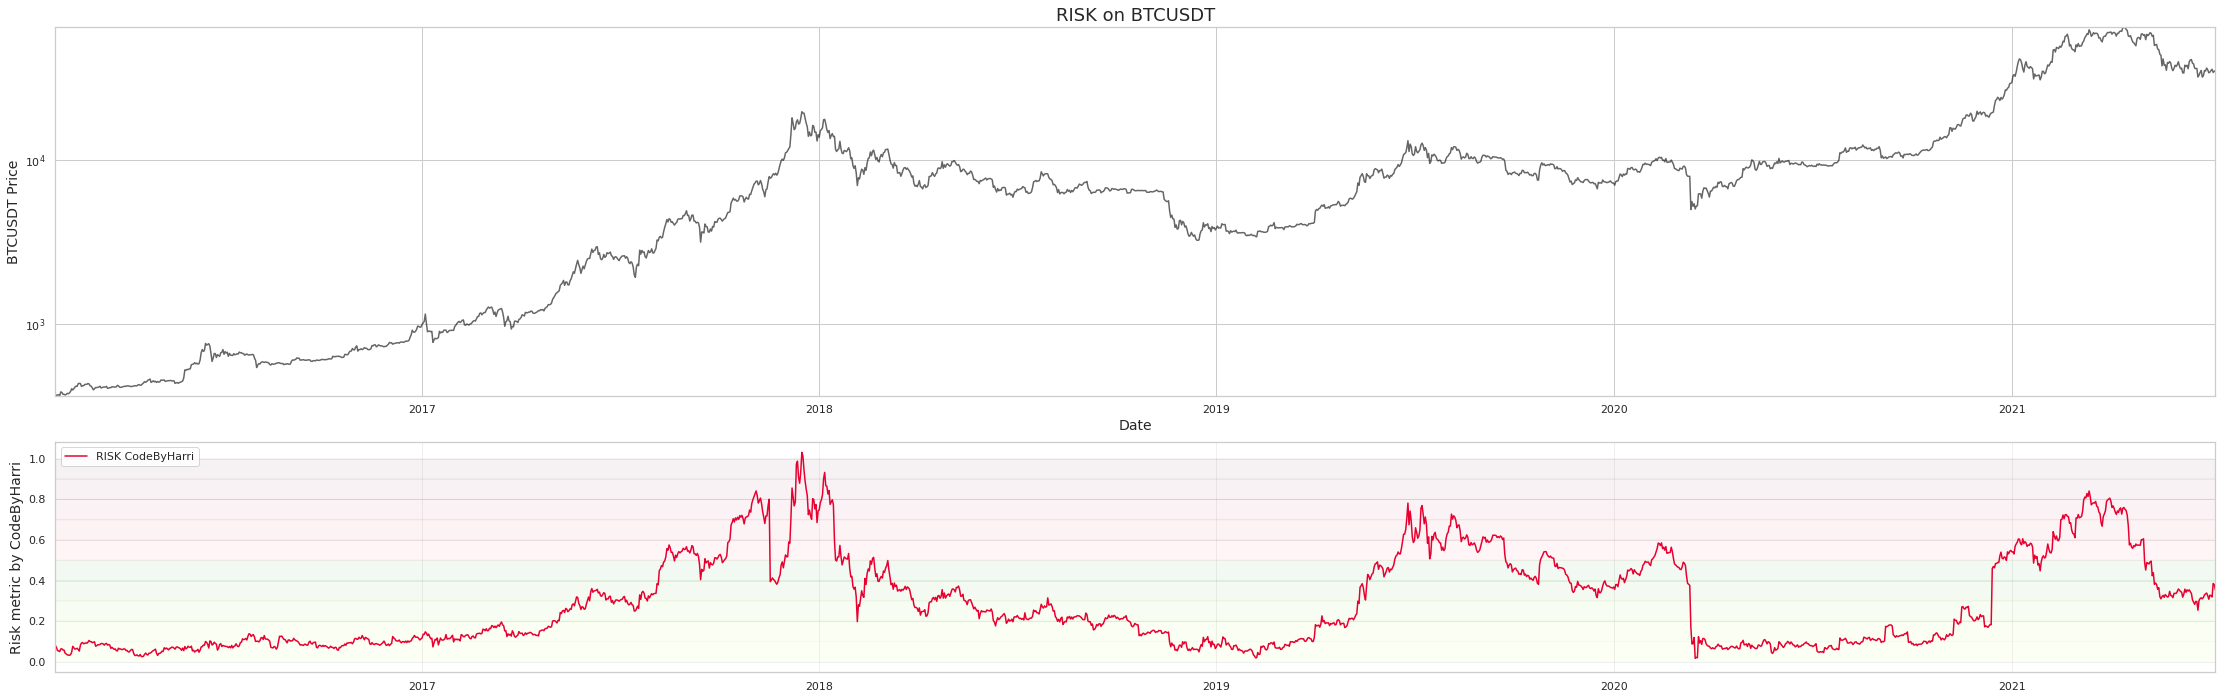

In [21]:
#hide_input
def pplot2(X,y,n,tick, predictions):
  sns.set_style("whitegrid")

  fig = plt.figure()
  fig.set_size_inches((30, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))
  ax2 = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax1)
  
  ax1.plot(y.index, y, label="Price",c = '#000000', alpha = 0.6)
  # ax2=ax1.twinx()
  
  ax2.fill_between(X.index, [1]*len(X), [0.9]*len(X), color= '#590D22', alpha = 0.05)
  ax2.fill_between(X.index, [0.9]*len(X), [0.8]*len(X), color= '#800F2F', alpha = 0.05)
  ax2.fill_between(X.index, [0.8]*len(X), [0.7]*len(X), color= '#A4133C', alpha = 0.05)
  ax2.fill_between(X.index, [0.7]*len(X), [0.6]*len(X), color= '#C9184A', alpha = 0.05)
  ax2.fill_between(X.index, [0.6]*len(X), [0.5]*len(X), color= '#FF4D6D', alpha = 0.05)
  ax2.fill_between(X.index, [0.5]*len(X), [0.4]*len(X), color= '#008000', alpha = 0.05)
  ax2.fill_between(X.index, [0.4]*len(X), [0.3]*len(X), color= '#38B000', alpha = 0.05)
  ax2.fill_between(X.index, [0.3]*len(X), [0.2]*len(X), color= '#70E000', alpha = 0.05)
  ax2.fill_between(X.index, [0.2]*len(X), [0.1]*len(X), color= '#9EF01A', alpha = 0.05)
  ax2.fill_between(X.index, [0.1]*len(X), [0]*len(X), color= '#CCFF33', alpha = 0.05)
  ax2.plot(X.index, predictions, label="RISK CodeByHarri",c = '#e80030', alpha = 1)

  ax1.set_title(f'RISK on {tick}', size=18)
  ax1.set_ylabel(f'{tick} Price', size=14)
  ax2.set_ylabel('Risk metric by CodeByHarri', size=14)
  ax1.set_xlabel('Date', size=14)
  ax1.set_yscale('log')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.legend(loc = 'upper left')
  ax1.axis([ y.index[n], max(y.index),min(y[y.index[n]:max(y.index)]),max(y[y.index[n]:max(y.index)])])
  plt.show()

X, y = ready2(dayd,weekd)
et_preds = best_et.predict(X)
rf_preds = best_rf.predict(X)
lreg_preds = best_lreg.predict(X)
preds = ( lreg_preds + rf_preds +  et_preds) / 3
pplot2(X,y,500,'BTCUSDT',preds)
# pplot2(X,y,2000,'BTCUSDT',preds)

## How is the risk calculated?
Given the BTCUSD data from Yahoo Finance 8 features are created, listed belowed in the diagram. These 8 features are used to predict the normalised price between local highs and lows. The models used are sklearns Extra Trees, Random Forrest and Linear Regression. This process is optimised using Optuna.

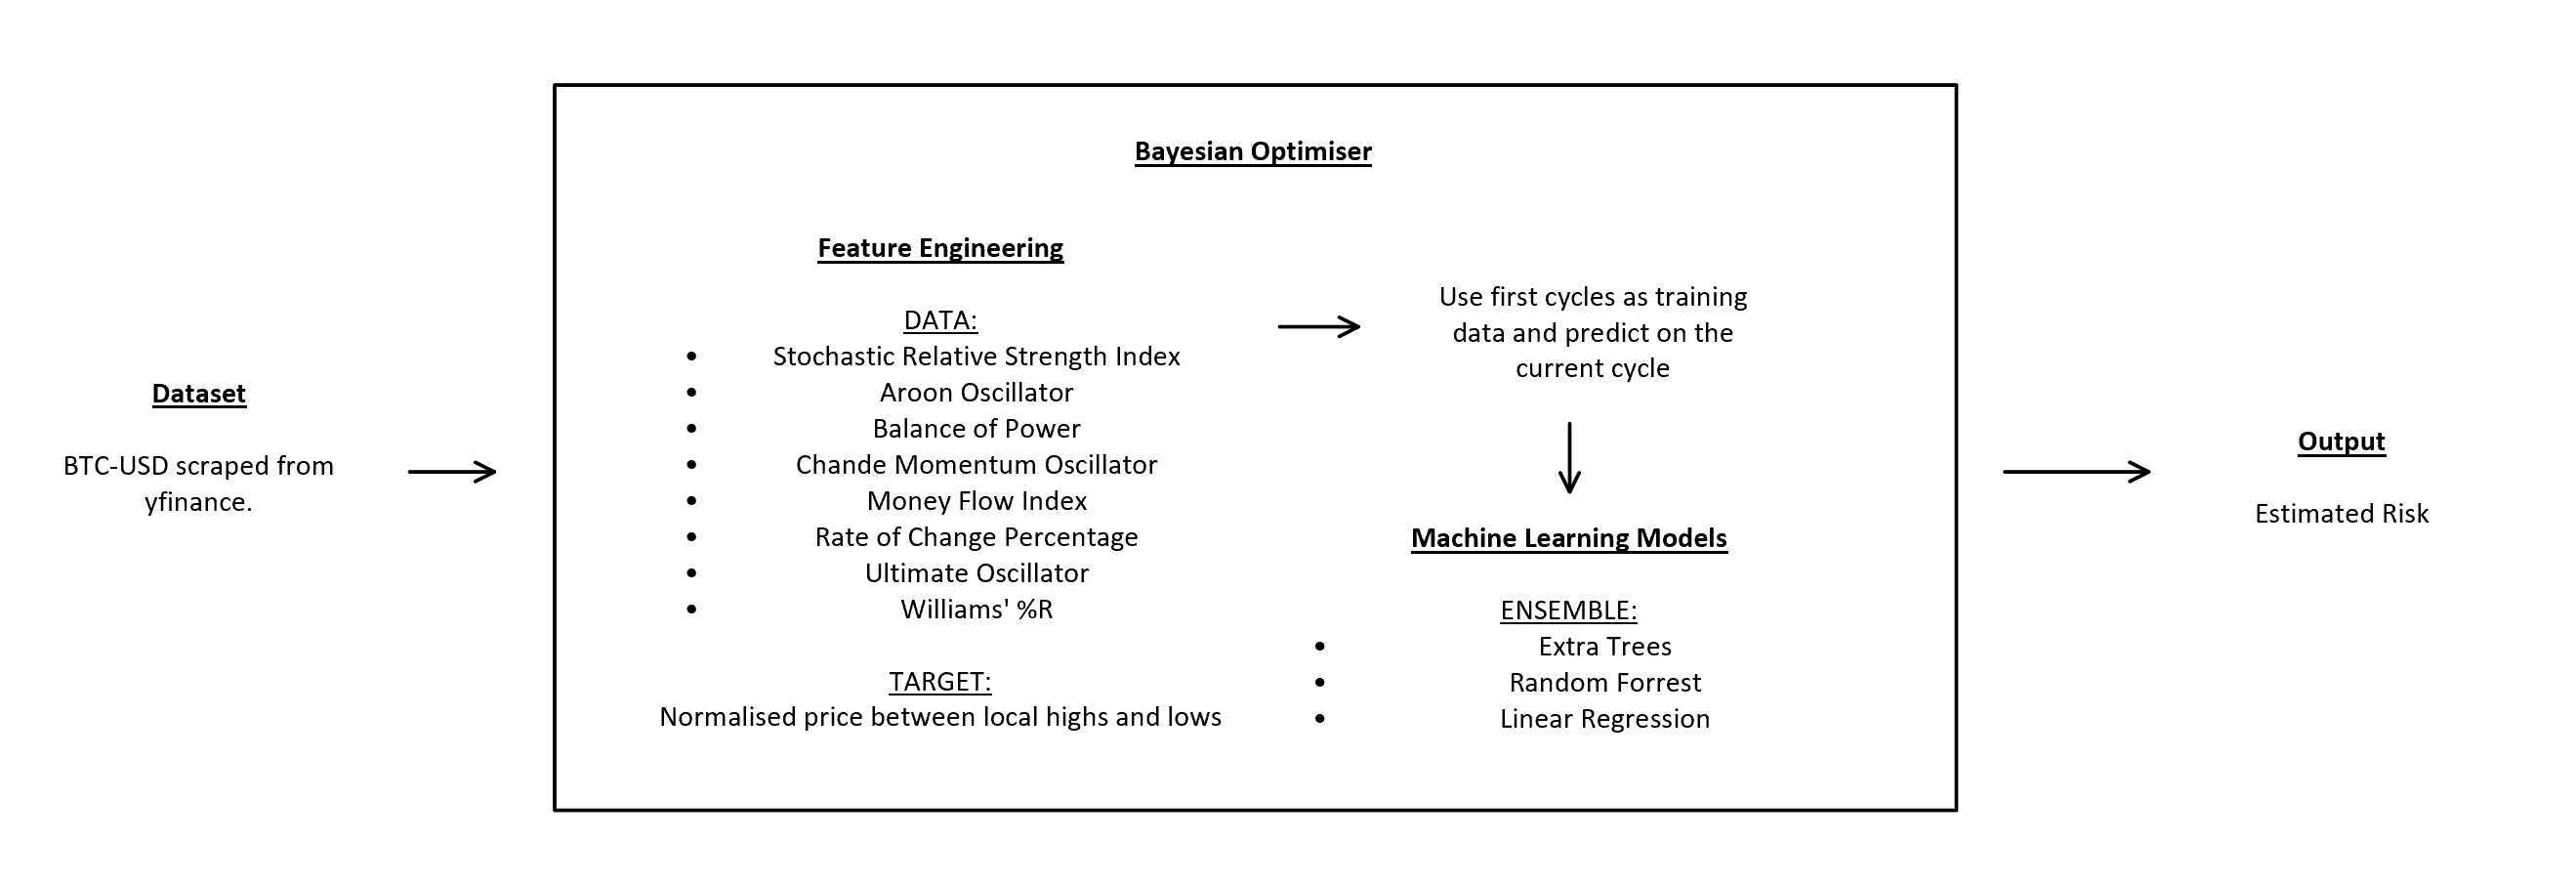

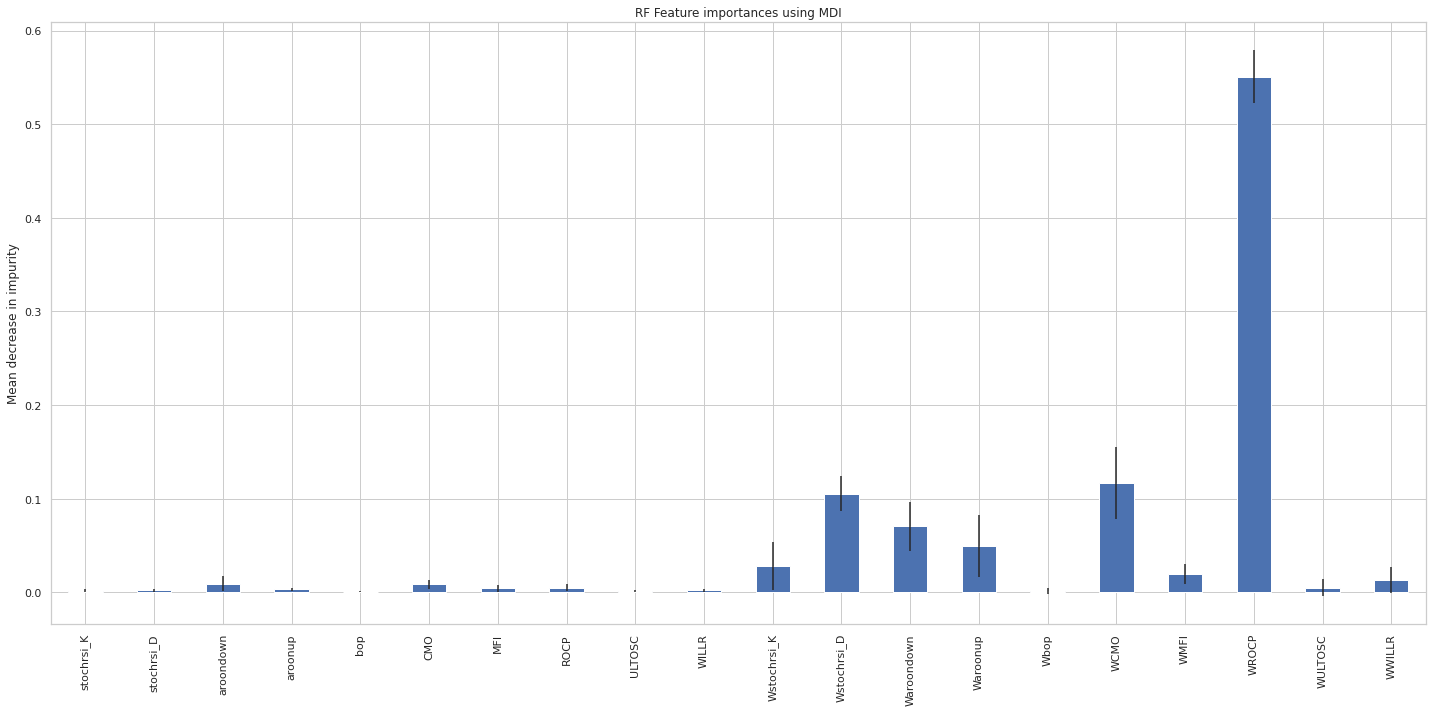

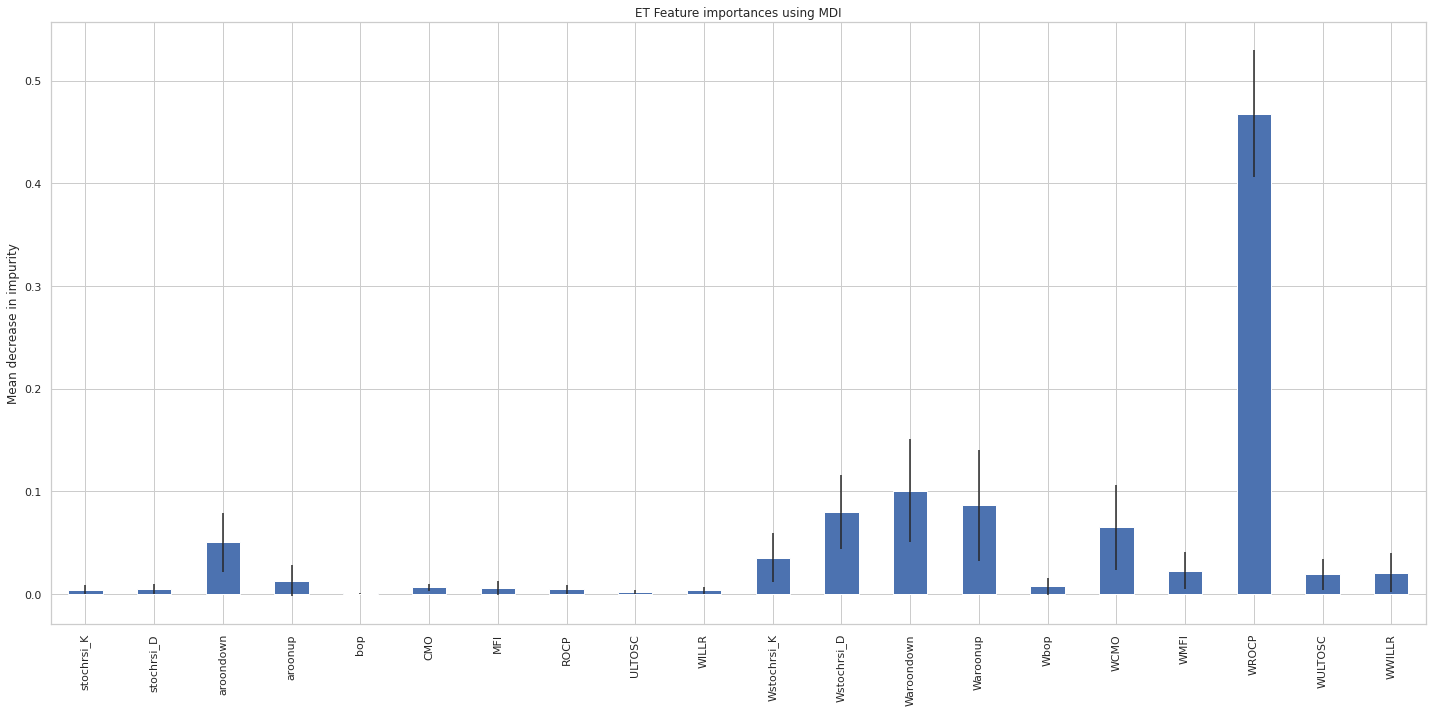

In [20]:
#hide
X , y = ready2(dayd,weekd)
feature_names = X.columns #[f'feature {i}' for i in range(X.shape[1])]
importances = best_rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("RF Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

importances = best_et.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in best_et.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("ET Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
#hide
# for i,tick in enumerate(['BTCUSDT','ETHUSDT','ADAUSDT']):
#   data, x = read(tick)
#   data["DATE"] = data.index
#   data = pp(data, x)
#   data = data.dropna()
#   data.loc['2017-09-16':'2018-12-15',"true"] = (data.loc['2017-09-16':'2018-12-15',"close"]-data.loc['2017-09-16':'2018-12-15',"close"].min())/(data.loc['2017-09-16':'2018-12-15',"close"].max()-data.loc['2017-09-16':'2018-12-15',"close"].min()) 
#   data.loc['2018-12-15':'2020-03-13',"true"] = (data.loc['2018-12-15':'2020-03-13',"close"]-data.loc['2018-12-15':'2020-03-13',"close"].min())/(data.loc['2018-12-15':'2020-03-13',"close"].max()-data.loc['2018-12-15':'2020-03-13',"close"].min()) 
#   data.loc['2020-03-13':,"true"] = (data.loc['2020-03-13':,"close"]-data.loc['2020-03-13':,"close"].min())/(data.loc['2020-03-13':,"close"].max()-data.loc['2020-03-13':,"close"].min())
#   data['tick'] = i
#   data = data.iloc[:,np.r_[0:5,6:8,12:21]]
#   y = data.pop('true')
#   X = data
#   X_xbg = xgb.DMatrix(X, label=y)
#   et_preds = best_et.predict(X)
#   rf_preds = best_rf.predict(X)
#   xgb_preds = best_xgb.predict(X_xbg)
#   preds = ( xgb_preds + rf_preds +  et_preds) / 3
#   pplot2(X,y,tick,preds)

In [ ]:
#hide
# data = read('BTCUSDT')
# data["DATE"] = data.index

# # {'p_': 167, 'k_': 68, 'd_': 16, 'a': -0.539573022590105, 'b': -2.2691025951852914, 'g': -4.791537273497448, 'l': 2.5786007461589775, 'n': -1.761569996393645, 'm': 2.3423724556099814}. Best is trial 821 with value: 19177.511792456426.



# # 28 56 57


# print('821')
# t821 = pp(data, 167, 68, 16, -0.539573022590105, -2.2691025951852914, -4.791537273497448, 2.5786007461589775, -1.761569996393645, 2.3423724556099814)
# with HiddenPrints():
#   VALUE, REALRISK = findvalue(data, 167, 68, 16, -0.539573022590105, -2.2691025951852914, -4.791537273497448, 2.5786007461589775, -1.761569996393645, 2.3423724556099814)
# t821 = pd.concat([t821, REALRISK], axis=1)
# t821["REALRISK"] = t821["REALRISK"].ffill()
# plot(t821,len(t821),'BTCUSDT')

# data = pp(data,149,13,8,a=-4.082143186417409,b=0.3333503916522253,g=4.526907907652845,
#        l=3.1715880036661863,n=4.9882317023888465,m=4.345832022189371)

# plot(data,len(data),'BTCUSDT')

In [ ]:
#hide
# with HiddenPrints():
#   VALUE, REALRISK = findvalue(data, 167, 68, 16, -0.539573022590105, -2.2691025951852914, -4.791537273497448, 2.5786007461589775, -1.761569996393645, 2.3423724556099814)
# REALRISK

In [ ]:
#hide
# REALRISK = REALRISK.set_index("DATE")

# TEMP = pd.concat([t821, REALRISK], axis=1)
# TEMP["REALRISK"] = TEMP["REALRISK"].ffill()
# TEMP.tail(50)

In [ ]:
#hide
!pip install optuna
from itertools import combinations 

import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout